# Homework 2 - Vertical FL and Generative Modeling

Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, the latter creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 

# Instructions

Submit your assignment in ILIAS as only the Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.


In [1]:
import numpy as np

def radom_feature_set_creator(columns, num_clients):
    # Shuffle columns randomly
    np.random.shuffle(columns)
    # Split columns into 4 random groups
    split_columns = np.array_split(columns, num_clients)
    # Convert each split into a list
    cleaned_columns = [[str(item) for item in sublist] for sublist in split_columns]
    return cleaned_columns

In [2]:
# implemented a different training method than original one because we would not be able to get losses 
# and accuracy at each step of training.


import torch
def train_with_settings_updated(self, epochs, batch_sz, n_cli, cli_features, x, y):
    self.num_cli = n_cli
    self.cli_features = cli_features
    x = x.astype('float32')
    y = y.astype('float32')
    x_train = [torch.tensor(x[feats].values) for feats in cli_features]
    y_train = torch.tensor(y.values)
    num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
    stepwise_accuracy = []
    stepwise_losses = []
    for epoch in range(epochs):
        self.optimizer.zero_grad()
        total_loss = 0.0
        correct = 0.0
        total = 0.0
        for minibatch in range(num_batches):
            if minibatch == num_batches - 1:
                x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                y_minibatch = y_train[int(minibatch * batch_sz):]
            else:
                x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]
            outs = self.forward(x_minibatch)
            pred = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_minibatch, dim=1)
            correct += torch.sum((pred == actual))
            total += len(actual)
            loss = self.criterion(outs, y_minibatch)
            total_loss += loss
            loss.backward()
            self.optimizer.step()

        # Added logic to store accuracy and losses at each step
        stepwise_accuracy.append(correct * 100 / total)
        stepwise_losses.append(total_loss.detach().numpy()/num_batches)

        print(
            f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}")
        
    # return them for logging and visualizations
    return stepwise_accuracy, stepwise_losses



In [3]:
# Adding the above method to VFLNetwork class so it can use attributes from VFLNetwork instance

from tutorial_2b.vfl import VFLNetwork
setattr(VFLNetwork, "train_with_settings_updated", train_with_settings_updated)


## Exercise 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_2b/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **3** random feature permutations and plot the training loss. Report whether/how shuffling features significantly affects the convergence rates and the reasoning behind it.

### _(1 point)_ Create 3 feature permutations with seeded Python/NumPy random functions and run them through the discriminative VFL model.

In [5]:
# Create 3 feature permutations with seeded Python/NumPy 
# random functions and run them through the discriminative VFL model.

import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tutorial_2b.vfl import BottomModel, VFLNetwork

def modified_main_method():
    df = pd.read_csv("tutorial_2a/heart.csv")
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    num_clients = 4
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    encoded_df_feature_names = list(X.columns)
    all_feature_names = list(df.columns)
    all_feature_names.pop()

    # defining total number of permutations we want to create
    total_permutation = 3

    # Storing metrics for later logging and visualisations
    metrics_list = []
    column_permutation_list = []
    model_summary = []

    # loop for each permutation
    for perm in range(total_permutation):
        # seed value
        torch.manual_seed(perm)
        np.random.seed(perm)

        #  Implemented a random feature set creator
        client_feature_names = radom_feature_set_creator(all_feature_names, num_clients)

        # adding encodings for categorical columns
        for i in range(len(client_feature_names)):
            updated_names = []
            for column_name in client_feature_names[i]:
                if column_name not in categorical_cols:
                    updated_names.append(column_name)
                else:
                    for name in encoded_df_feature_names:
                        if '_' in name and column_name in name:
                            updated_names.append(name)
            client_feature_names[i] = updated_names
        
        outs_per_client = 2
        bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
        final_out_dims = 2
        Network = VFLNetwork(bottom_models, final_out_dims)

        EPOCHS = 300
        BATCH_SIZE = 64
        TRAIN_TEST_THRESH = 0.8
        X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
        Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
        stepwise_accuracy, stepwise_losses = Network.train_with_settings_updated(EPOCHS, BATCH_SIZE, num_clients,
                                    client_feature_names, X_train, Y_train)

        # Storing metrics
        accuracy, loss = Network.test(X_test, Y_test)
        metrics_list.append([accuracy, loss])
        column_permutation_list.append(client_feature_names)
        model_summary.append([stepwise_accuracy, stepwise_losses])

    return metrics_list, column_permutation_list, model_summary

metrics_list, column_permutation_list, model_summary = modified_main_method()



Epoch: 0 Train accuracy: 51.64% Loss: 0.693
Epoch: 1 Train accuracy: 53.59% Loss: 0.685
Epoch: 2 Train accuracy: 55.54% Loss: 0.647
Epoch: 3 Train accuracy: 81.49% Loss: 0.603
Epoch: 4 Train accuracy: 78.93% Loss: 0.507
Epoch: 5 Train accuracy: 64.80% Loss: 0.678
Epoch: 6 Train accuracy: 79.05% Loss: 0.497
Epoch: 7 Train accuracy: 79.90% Loss: 0.497
Epoch: 8 Train accuracy: 84.65% Loss: 0.440
Epoch: 9 Train accuracy: 83.68% Loss: 0.384
Epoch: 10 Train accuracy: 85.87% Loss: 0.366
Epoch: 11 Train accuracy: 86.85% Loss: 0.355
Epoch: 12 Train accuracy: 87.21% Loss: 0.355
Epoch: 13 Train accuracy: 86.48% Loss: 0.342
Epoch: 14 Train accuracy: 86.72% Loss: 0.334
Epoch: 15 Train accuracy: 86.72% Loss: 0.353
Epoch: 16 Train accuracy: 87.21% Loss: 0.351
Epoch: 17 Train accuracy: 88.67% Loss: 0.338
Epoch: 18 Train accuracy: 87.94% Loss: 0.327
Epoch: 19 Train accuracy: 88.31% Loss: 0.324
Epoch: 20 Train accuracy: 88.67% Loss: 0.314
Epoch: 21 Train accuracy: 88.43% Loss: 0.327
Epoch: 22 Train accu

In [6]:
# This cell will let you know what all permutations were created

column_sets = []
perm = 1
for permutation in column_permutation_list:
    column_permutation = []

    for item in permutation:
        column_list = [x.split("_")[0] for x in item]
        column_list = set(column_list)
        column_permutation.append(list(column_list))
    column_sets.append(column_permutation)
    print(f"------ Column segregation for permutation {perm} ------")
    print(column_permutation)
    perm += 1

column_sets = list(column_sets)

------ Column segregation for permutation 1 ------
[['restecg', 'slope', 'chol', 'ca'], ['exang', 'cp', 'sex'], ['trestbps', 'thalach', 'oldpeak'], ['fbs', 'age', 'thal']]
------ Column segregation for permutation 2 ------
[['age', 'cp', 'slope', 'chol'], ['restecg', 'sex', 'ca'], ['trestbps', 'thal', 'thalach'], ['fbs', 'exang', 'oldpeak']]
------ Column segregation for permutation 3 ------
[['sex', 'oldpeak', 'chol', 'ca'], ['trestbps', 'age', 'slope'], ['fbs', 'thalach', 'cp'], ['thal', 'restecg', 'exang']]


### _(1 point)_ Log the losses over time of the training runs and compile them into one plot.


In [7]:
# Final information for each permutation after training
for idx in range(len(metrics_list)):
    print(f"--------------------- permutation {idx+1} ---------------------")
    print("For column set:")
    print(str(column_permutation_list[idx]))
    print(f"Final test accuracy: {metrics_list[idx][0] * 100:.2f}%")
    print(f"Final loss: {metrics_list[idx][1]:.2f}")


--------------------- permutation 1 ---------------------
For column set:
[['restecg_0', 'restecg_1', 'restecg_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'chol', 'slope_0', 'slope_1', 'slope_2'], ['cp_0', 'cp_1', 'cp_2', 'cp_3', 'exang_0', 'exang_1', 'sex_0', 'sex_1'], ['thalach', 'oldpeak', 'trestbps'], ['age', 'fbs_0', 'fbs_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Final test accuracy: 86.27%
Final loss: 0.27
--------------------- permutation 2 ---------------------
For column set:
[['chol', 'slope_0', 'slope_1', 'slope_2', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'age'], ['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'sex_0', 'sex_1', 'restecg_0', 'restecg_1', 'restecg_2'], ['thalach', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'trestbps'], ['oldpeak', 'fbs_0', 'fbs_1', 'exang_0', 'exang_1']]
Final test accuracy: 94.12%
Final loss: 0.35
--------------------- permutation 3 ---------------------
For column set:
[['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'chol', 'oldpeak', 'sex_0', 'sex_1'], ['age', 

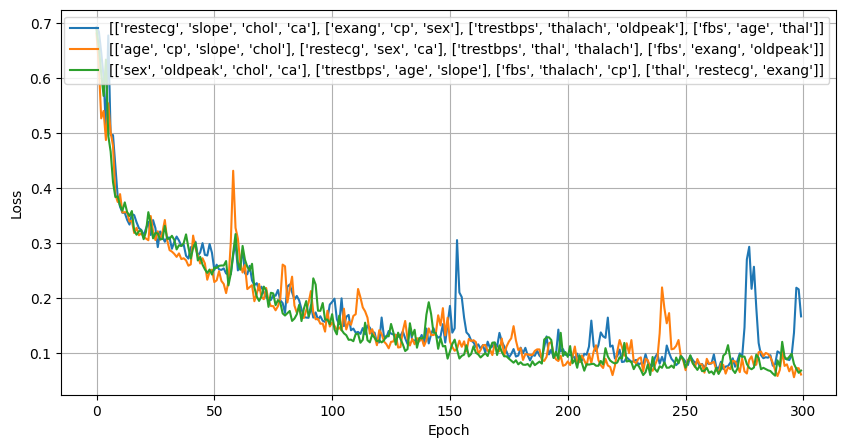

In [8]:
# Plotting losses

import matplotlib.pyplot as plt

# Extract values for the three lines
x = np.arange(300)  # X-axis from 0 to 299
model_summary = np.array(model_summary)
y1 = model_summary[0, 1, :]   # First line
y2 = model_summary[1, 1, :]   # Second line
y3 = model_summary[2, 1, :]   # Third line

# Plot the lines
plt.figure(figsize=(10, 5))
plt.plot(x, y1, label=str(column_sets[0]))
plt.plot(x, y2, label=str(column_sets[1]))
plt.plot(x, y3, label=str(column_sets[2]))

# Add labels, legend, and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### _(2 points)_ Describe what impact (if any) the permutations have on the loss and explain the observed pattern.

Answer - 
Referring to the graph above, we can see that each permutation provides almost equal results in loss convergence. If we create an average moving line for each of them, we would see blue line converging to a higher loss and others converging to smaller losses. While the difference is not a lot in our case, but it can happen in real world that we see a big difference in converged loss (as client model wont be fit for the features it is providing).

One more point to note is that the convergence is not smooth, there are a lot of spikes. This is generally expected from vertical federated learning results. Also we see much larger spikes in blue curve whereas green is smoother.

## Exercise 2: Scaling clients in VFL (5 points)

With the same template as above, experiment with how increasing the number of clients affects model performance. Explain the policy chosen for distributing features for different numbers of clients.

### _(1 point)_ Explain your scheme for partitioning the feature space under increasing number of clients.

Answer - I will create 4 scenarios with num_clients = 3, 4, 5, 6 with column permutation as first come first serve and trying to keep equal number of features assigned to each client

example, for columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'] and num_clients = 3
    
the feature assignment will be [['age', 'sex', 'cp', 'trestbps'], ['chol', 'fbs', 'restecg', 'thalach'], ['exang', 'oldpeak', 'slope', 'ca', 'thal']]

The first come first serve will make sure that random feature assignment is not affecting our inferences (so that model performance difference is not due to feature selection and only from varying number of clients).

### _(1 point)_ Implement the above explained partition mechanism for the requested client counts

In [10]:
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tutorial_2b.vfl import BottomModel, VFLNetwork

def modified_main_method():
    df = pd.read_csv("tutorial_2a/heart.csv")
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    encoded_df_feature_names = list(X.columns)
    all_feature_names = list(df.columns)
    all_feature_names.pop()

    # Storing metrics for later logging and visualisations
    metrics_list = []
    column_permutation_list = []
    model_summary = []

    # using an array to store num_clients so we can apply a loop
    num_clients_list = [1, 2, 3, 4, 5, 6]
    
    # Training and storing losses and metrics for each permutation
    for perm in range(len(num_clients_list)):
        # seed value
        torch.manual_seed(perm)
        np.random.seed(perm)

        # logic for permutation creation starts here. logic is same as originally provided in tutorial_1b
        num_clients = num_clients_list[perm]
        features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]  # "equally" partition the features
        features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
        features_per_client = np.array(features_per_client)
        client_feature_names = []
        start_index = 0

        for num_feats in features_per_client:
            feat_names = all_feature_names[start_index:start_index + num_feats]
            client_feature_names.append(feat_names)
            start_index = start_index + num_feats
        
        for i in range(len(client_feature_names)):
            updated_names = []
            for column_name in client_feature_names[i]:
                if column_name not in categorical_cols:
                    updated_names.append(column_name)
                else:
                    for name in encoded_df_feature_names:
                        if '_' in name and column_name in name:
                            updated_names.append(name)
            client_feature_names[i] = updated_names
        

        outs_per_client = 2
        bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
        final_out_dims = 2
        Network = VFLNetwork(bottom_models, final_out_dims)

        EPOCHS = 300
        BATCH_SIZE = 64
        TRAIN_TEST_THRESH = 0.8
        X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
        Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
        stepwise_accuracy, stepwise_losses = Network.train_with_settings_updated(EPOCHS, BATCH_SIZE, num_clients,
                                    client_feature_names, X_train, Y_train)

        # storing metrics for each permutation
        accuracy, loss = Network.test(X_test, Y_test)
        metrics_list.append([accuracy, loss])
        column_permutation_list.append(client_feature_names)
        model_summary.append([stepwise_accuracy, stepwise_losses])

    return metrics_list, column_permutation_list, model_summary

metrics_list, column_permutation_list, model_summary = modified_main_method()

Epoch: 0 Train accuracy: 58.10% Loss: 0.688
Epoch: 1 Train accuracy: 66.99% Loss: 0.616
Epoch: 2 Train accuracy: 81.49% Loss: 0.469
Epoch: 3 Train accuracy: 84.29% Loss: 0.458
Epoch: 4 Train accuracy: 84.29% Loss: 0.407
Epoch: 5 Train accuracy: 83.68% Loss: 0.395
Epoch: 6 Train accuracy: 79.17% Loss: 0.463
Epoch: 7 Train accuracy: 82.34% Loss: 0.513
Epoch: 8 Train accuracy: 86.11% Loss: 0.402
Epoch: 9 Train accuracy: 86.97% Loss: 0.392
Epoch: 10 Train accuracy: 88.79% Loss: 0.332
Epoch: 11 Train accuracy: 88.67% Loss: 0.332
Epoch: 12 Train accuracy: 89.16% Loss: 0.318
Epoch: 13 Train accuracy: 90.50% Loss: 0.307
Epoch: 14 Train accuracy: 90.38% Loss: 0.295
Epoch: 15 Train accuracy: 90.74% Loss: 0.285
Epoch: 16 Train accuracy: 92.45% Loss: 0.262
Epoch: 17 Train accuracy: 89.52% Loss: 0.287
Epoch: 18 Train accuracy: 88.55% Loss: 0.305
Epoch: 19 Train accuracy: 91.72% Loss: 0.271
Epoch: 20 Train accuracy: 92.20% Loss: 0.252
Epoch: 21 Train accuracy: 90.74% Loss: 0.274
Epoch: 22 Train accu

In [14]:
# Logging how each permutation looks like

column_sets = []
perm = 1
for permutation in column_permutation_list:
    column_permutation = []

    for item in permutation:
        column_list = [x.split("_")[0] for x in item]
        column_list = set(column_list)
        column_permutation.append(list(column_list))
    column_sets.append(column_permutation)
    print(f"------ Column segregation for permutation {perm} ------")
    print(column_permutation)
    perm += 1

column_sets = list(column_sets)

------ Column segregation for permutation 1 ------
[['thalach', 'cp', 'thal', 'sex', 'exang', 'slope', 'trestbps', 'age', 'fbs', 'chol', 'restecg', 'oldpeak', 'ca']]
------ Column segregation for permutation 2 ------
[['cp', 'sex', 'trestbps', 'age', 'fbs', 'chol'], ['thalach', 'thal', 'exang', 'slope', 'restecg', 'oldpeak', 'ca']]
------ Column segregation for permutation 3 ------
[['trestbps', 'age', 'cp', 'sex'], ['fbs', 'restecg', 'chol', 'thalach'], ['thal', 'exang', 'slope', 'oldpeak', 'ca']]
------ Column segregation for permutation 4 ------
[['age', 'cp', 'sex'], ['trestbps', 'fbs', 'chol'], ['restecg', 'exang', 'thalach'], ['thal', 'slope', 'oldpeak', 'ca']]
------ Column segregation for permutation 5 ------
[['age', 'sex'], ['trestbps', 'cp'], ['fbs', 'chol'], ['restecg', 'thalach'], ['thal', 'exang', 'slope', 'oldpeak', 'ca']]
------ Column segregation for permutation 6 ------
[['age', 'sex'], ['trestbps', 'cp'], ['fbs', 'chol'], ['restecg', 'thalach'], ['exang', 'oldpeak'],

### _(1 point)_ Log the losses over time of the training runs and compile them into one plot.


In [12]:
# Final losses and info about different permutations

for idx in range(len(metrics_list)):
    print(f"--------------------- permutation {idx+1} ---------------------")
    print("For column set:")
    print(str(column_permutation_list[idx]))
    print(f"Final test accuracy: {metrics_list[idx][0] * 100:.2f}%")
    print(f"Final loss: {metrics_list[idx][1]:.2f}")

--------------------- permutation 1 ---------------------
For column set:
[['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps', 'chol', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'thalach', 'exang_0', 'exang_1', 'oldpeak', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Final test accuracy: 89.71%
Final loss: 2.17
--------------------- permutation 2 ---------------------
For column set:
[['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps', 'chol', 'fbs_0', 'fbs_1'], ['restecg_0', 'restecg_1', 'restecg_2', 'thalach', 'exang_0', 'exang_1', 'oldpeak', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]
Final test accuracy: 94.61%
Final loss: 0.42
--------------------- permutation 3 ---------------------
For column set:
[['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'trestbps'], ['chol', 'fbs_0', 'fbs_1',

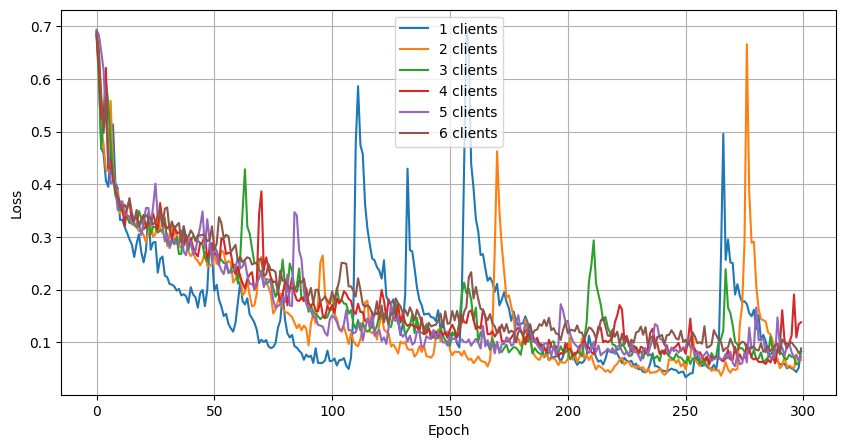

In [13]:
# Plotting results

import matplotlib.pyplot as plt

# Extract values for the three lines
x = np.arange(300)  # X-axis from 0 to 299
model_summary = np.array(model_summary)
y1 = model_summary[0, 1, :]   # First line
y2 = model_summary[1, 1, :]   # Second line
y3 = model_summary[2, 1, :]   # Third line
y4 = model_summary[3, 1, :]   # Fourth line
y5 = model_summary[4, 1, :]   # Fifth line
y6 = model_summary[5, 1, :]   # sixth line



# Plot the lines
plt.figure(figsize=(10, 5))
plt.plot(x, y1, label="1 clients")
plt.plot(x, y2, label="2 clients")
plt.plot(x, y3, label="3 clients")
plt.plot(x, y4, label="4 clients")
plt.plot(x, y5, label="5 clients")
plt.plot(x, y6, label="6 clients")

# Add labels, legend, and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

Answer - We see a clear distinction in the loss convergence with increasing number of clients. When num_clients 1 or 2 then model performs better (loss converging at a lower value) than the cases when num_clients = 3,4,5,6.

While performance with num_clients >= 3 is not so well, we see that there is no clear distinction in model performances with changing permutations.

Also, with num_clients = 2, the loss seems to be converging to the same value as that of num_clients = 1, but taking more epochs to do so.

## Exercise 3: Bridging VFL and generative modeling (10 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. Combine VFL with variational autoencoders (VAEs) using the architecture described as follows. Each client uses a local encoder, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another local MLP (decoder) at each client. Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features.
- _(2 points)_ Define the encoder and decoder MLPs held by each client.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.
- _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?
- _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.

### For any questions regarding this assignment, send an email to a.shankar@tudelft.nl

### _(1 point)_ Preprocess the dataset and partition the features.

In [15]:
# As we are now using this not for prediction, we want to keep the target value in our real_data
# Hence, while creating column permutation, one client is also containing the target column (in encoded form)
# While server was the one with 'target' feature in original implementation, this time it is not like that.

import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


torch.manual_seed(42)
np.random.seed(42)
df = pd.read_csv("tutorial_2a/heart.csv")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])
encoded_df = pd.get_dummies(df, columns=categorical_cols)
num_clients = 4
X = encoded_df
features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]
features_per_client.append(len(df.columns) - sum(features_per_client))
features_per_client = np.array(features_per_client)
all_feature_names = list(df.columns)
client_feature_names = []
csum_features_per_client = np.cumsum(features_per_client)
encoded_df_feature_names = list(X.columns)
start_index = 0
end_index = 0

for num_feats in features_per_client:
    feat_names = all_feature_names[start_index:start_index + num_feats]
    client_feature_names.append(feat_names)
    start_index = start_index + num_feats

for i in range(len(client_feature_names)):
    updated_names = []
    for column_name in client_feature_names[i]:
        if column_name not in categorical_cols:
            updated_names.append(column_name)
        else:
            for name in encoded_df_feature_names:
                if '_' in name and column_name in name:
                    updated_names.append(name)
    client_feature_names[i] = updated_names

client_feature_names

[['age', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3'],
 ['trestbps', 'chol', 'fbs_0', 'fbs_1'],
 ['restecg_0', 'restecg_1', 'restecg_2', 'thalach', 'exang_0', 'exang_1'],
 ['oldpeak',
  'slope_0',
  'slope_1',
  'slope_2',
  'ca_0',
  'ca_1',
  'ca_2',
  'ca_3',
  'ca_4',
  'thal_0',
  'thal_1',
  'thal_2',
  'thal_3',
  'target_0',
  'target_1']]

### _(2 points)_ Define the encoder and decoder MLPs held by each client.


In [16]:
# While most of the implementation is same as the original one, we need to decide which methods
# are going to be useful in our case. Also, there is change according to number of input and output features

from torch import nn
import torch.nn.functional as F

class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat, H=50, H2=12, latent_dim=3):
        #         # Non VAE part
        super(BottomModel, self).__init__()
        self.local_out_dim = latent_dim

        #         # Encoder
        self.optimizer = None
        self.criterion = None
        self.linear1 = nn.Linear(in_feat, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        #         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        #         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        #         # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, in_feat)
        self.lin_bn6 = nn.BatchNorm1d(num_features=in_feat)

        self.relu = nn.ReLU()
    
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2
    
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu



### _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.

In [17]:
# While most of the implementation is same as the original one, we need to decide which methods
# are going to be useful in our case. Also, there is change according to number of input and output features

class TopModel(nn.Module):
    def __init__(self, local_models, n_outs, H=50, H2=12, latent_dim=3):
        #         # Non VAE part
        super(TopModel, self).__init__()
        self.in_size = sum([local_models[i].local_out_dim for i in range(len(local_models))])
    
        # Encoder
        self.optimizer = None
        self.criterion = None
        self.linear1 = nn.Linear(self.in_size, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        #         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        #         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        #         # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, self.in_size)
        self.lin_bn6 = nn.BatchNorm1d(num_features=self.in_size)

        self.relu = nn.ReLU()
        
    
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu


### _(2 points)_ Define the VFL network that fits together the client networks and that of the server.


In [20]:
import torch.optim as optim

class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = None

        # This was required to be added to complete forward passing of embedded features from 
        # server back to clients
        self.n_outs = n_outs

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, loss_criterion):
        self.num_cli = n_cli
        self.cli_features = cli_features
        self.criterion = loss_criterion
        x = x.astype('float32')
        x_train = None

        #  accumulating all latents recieved from clients
        for feat_array in cli_features:
            temp_array = np.array([x[feat] for feat in feat_array])
            if x_train is None:
                x_train = temp_array
            else:
                x_train = np.vstack((x_train, temp_array))
        
        # creating tensor to pass for training
        x_train = torch.tensor(x_train, dtype=torch.float32)
        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = np.array([x[int(minibatch * batch_sz):] for x in x_train])
                else:
                    x_minibatch = np.array([x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train])

                real_data = torch.tensor(x_minibatch.T)
                outs, mu, logvar = self.forward(real_data)
                
                loss = self.criterion(outs, real_data, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            print(
                f"Epoch: {epoch} Loss: {total_loss.detach().numpy() / num_batches:.3f}")

    # updated forward method
    def forward(self, x):

        # initialized an empty tensor to store input latents provided by clients
        bottom_results = torch.empty((len(x), 0))
        start_idx = 0
        for i in range(self.num_cli):
            end_idx = start_idx + len(self.cli_features[i])
            # getting reparametrized values from bottom models
            mu_model, logvar_model = self.bottom_models[i].encode(torch.tensor(x[:, start_idx:end_idx]))
            # reparameterized_values = self.bottom_models[i].reparameterize(mu_model, logvar_model)
            # accumulating them into a single tensor
            # bottom_results = torch.cat((bottom_results, reparameterized_values), dim=1)
            bottom_results = torch.cat((bottom_results, mu_model), dim=1)
            start_idx = end_idx

        # applying encoding and creation of latent features at the server (top model)
        mu, logvar = self.top_model.encode(bottom_results)
        z = self.top_model.reparameterize(mu, logvar)

        # decoding in server
        z_top_model = self.top_model.decode(z)

        # sending latents to bottom models so that features can be recreated
        start_idx = 0
        z_final = None
        for i in range(self.num_cli):
            end_idx = start_idx + self.n_outs
            # decoding latents in clients to get z_final that will be our artificially created data
            z_bottom_model = self.bottom_models[i].decode(z_top_model[:, start_idx:end_idx])
            if z_final is None:
                z_final = z_bottom_model
            else:
                z_final = torch.cat((z_final, z_bottom_model), dim=1)
            start_idx = end_idx

        return z_final, mu, logvar


### _(1 point)_ Create and run the training loop of the complete model, including formulating the loss and printing it at every epoch.


In [21]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# creation of customLoss class to calculate loss
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

# client_feature_names was created in the first part of this section
outs_per_client = 2
bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
final_out_dims = 3
Network = VFLNetwork(bottom_models, final_out_dims)

loss_mse = customLoss()
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8
X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
# training with real data
Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                            client_feature_names, X_train, loss_mse)

/var/folders/0y/1vh1g37j61j0kv4hcjwfgm2h0000gn/T/ipykernel_14589/60032821.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_model, logvar_model = self.bottom_models[i].encode(torch.tensor(x[:, start_idx:end_idx]))


Epoch: 0 Loss: 2694.585
Epoch: 1 Loss: 2676.985
Epoch: 2 Loss: 2661.801
Epoch: 3 Loss: 2664.926
Epoch: 4 Loss: 2654.418
Epoch: 5 Loss: 2665.112
Epoch: 6 Loss: 2664.603
Epoch: 7 Loss: 2664.802
Epoch: 8 Loss: 2666.095
Epoch: 9 Loss: 2659.240
Epoch: 10 Loss: 2663.295
Epoch: 11 Loss: 2656.287
Epoch: 12 Loss: 2650.313
Epoch: 13 Loss: 2664.627
Epoch: 14 Loss: 2668.943
Epoch: 15 Loss: 2649.923
Epoch: 16 Loss: 2655.190
Epoch: 17 Loss: 2659.759
Epoch: 18 Loss: 2655.070
Epoch: 19 Loss: 2642.908
Epoch: 20 Loss: 2623.528
Epoch: 21 Loss: 2647.653
Epoch: 22 Loss: 2623.955
Epoch: 23 Loss: 2638.227
Epoch: 24 Loss: 2630.723
Epoch: 25 Loss: 2633.221
Epoch: 26 Loss: 2629.259
Epoch: 27 Loss: 2640.238
Epoch: 28 Loss: 2629.064
Epoch: 29 Loss: 2621.067
Epoch: 30 Loss: 2625.727
Epoch: 31 Loss: 2627.128
Epoch: 32 Loss: 2649.554
Epoch: 33 Loss: 2642.660
Epoch: 34 Loss: 2635.938
Epoch: 35 Loss: 2624.529
Epoch: 36 Loss: 2630.990
Epoch: 37 Loss: 2638.282
Epoch: 38 Loss: 2619.773
Epoch: 39 Loss: 2629.923
Epoch: 40 

### _(0.5 points)_ Consider, without implementing, an alternative scheme wherein the MLPs are first locally trained at the clients, followed by a separate training loop for the VAE at the server. How does this change what should be provided as input to the server?

Answer: If the MLPs in client are locally trained first, the latents provided by clients to server are already optimized, and provide embeddings to real data. So while backpropagating we dont have to update weights in the MLP clients.

Client use their frozen local encoders to produce embeddings for their features. These embeddings are sent to the server. The server directly uses these embeddings to train on the local VAE.

### _(1.5 points)_ What are the pros and cons of the above mentioned alternative compared to the one implemented? Focus on the following aspects: privacy, communication costs, and performance.

Answer: 
1. Peformance: 
-  In terms of computations, the alternative model requires less computations as once model is trained enough, we dont need to keep the model busy in training. Once trained we need to use it only for forward propogation.
- In terms of accuracy, in the alternative model, we would loose out on essential backpropagation updates because the local model are trained on just local data and not optimized for the final prediction that server is trying to make. Hence, accuracy is expected to be less in the alternative model.

2. Communication costs:
- In the alternative model, lower communication overhead will be faced during VAE training since clients only send latents once (after local training). No back-and-forth gradient updates between server and clients during VAE training.

3. Privacy:
- For the ALTERNATIVE SCHEME: Clients only send precomputed, frozen latent embeddings to the server, reducing exposure of raw data or dynamic updates. Since gradients do not flow back to clients during VAE training, there is no risk of gradient-based data leakage (e.g., via inversion attacks).
- For the ORIGINAL SCHEME: Latents are dynamically updated, making it harder for an adversary to reconstruct raw data from a single snapshot.Gradient updates sent back to clients could leak information (e.g., via model inversion attacks).Requires continuous trust in the server during training, as it sees latent updates in every epoch.